In [10]:
import os
import joblib
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
# Load preprocessed data
preprocessing_objects = joblib.load("../outputs/preprocessing_all.pkl")

df_final_encoded = preprocessing_objects["data"]
binary_encoder = preprocessing_objects["binary_encoder"]
multi_encoder = preprocessing_objects["multi_encoder"]

print("Preprocessed data loaded successfully!")
df_final_encoded.head()

# Define features and target
X = df_final_encoded.drop("Addicted_Score", axis=1)
y = df_final_encoded["Addicted_Score"]

# Load training data (train/test split and trained RF model)
model_training_path = "../outputs/model_training_data.pkl"

training_data = joblib.load(model_training_path)

# Extract variables
X = training_data["X"]
y = training_data["y"]
X_train = training_data["X_train"]
X_test = training_data["X_test"]
y_train = training_data["y_train"]
y_test = training_data["y_test"]
rf_model = training_data["rf_model"]

print("Model training data loaded successfully!")


Preprocessed data loaded successfully!
Model training data loaded successfully!


In [11]:
# Optional: Remove Highly Correlated Features (>0.85)
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.85)]
X_filtered = X.drop(columns=to_drop) if to_drop else X.copy()

print("Dropped due to high correlation:", to_drop)
print("Remaining features:", X_filtered.shape[1])
X_final = X_filtered


Dropped due to high correlation: ['Conflicts_Over_Social_Media', 'Relationship_Status_Single']
Remaining features: 20


**Code Explination**
- **What it does**:
    - Finds features that are strongly correlated with each other (`>0.85`).
    - Removes one of the redundant features to avoid **multicollinearity** (when two features give the same info).
    - Example: If "Daily Usage Hours" and "Addicted Score" are 0.9 correlated, one is dropped.
- **Why**:
   Too much correlation confuses models (especially linear models) because they don’t know which feature to trust.

In [12]:
# Feature Importance via Random Forest

rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_filtered, y)

,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


**Code Explination**
- **RandomForestRegressor** is used here (though for classification, `RandomForestClassifier` is more usual).
- Fits the model to predict target `y` using the **filtered features**.
- After training, Random Forest can tell **which features were important** for prediction.

In [13]:
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_filtered.columns, 'Importance': importances})
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Top 10 important features
print("\nTop 10 Important Features:")
print(feature_importance_df.head(10))


Top 10 Important Features:
                                Feature  Importance
3                   Mental_Health_Score    0.901062
2                 Sleep_Hours_Per_Night    0.029862
1                 Avg_Daily_Usage_Hours    0.020050
5      Affects_Academic_Performance_Yes    0.012262
9          Most_Used_Platform_KakaoTalk    0.007870
10              Most_Used_Platform_LINE    0.006249
8          Most_Used_Platform_Instagram    0.004298
13            Most_Used_Platform_TikTok    0.003492
19  Relationship_Status_In Relationship    0.003399
17          Most_Used_Platform_WhatsApp    0.003358


**Code Explination**
- Extracts **importance score** for each feature (higher = more important).
- Creates a DataFrame and sorts features by importance.
- Prints the **Top 10 features**.

C:\Users\ASUS1\AppData\Local\Temp\ipykernel_4268\2769857533.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


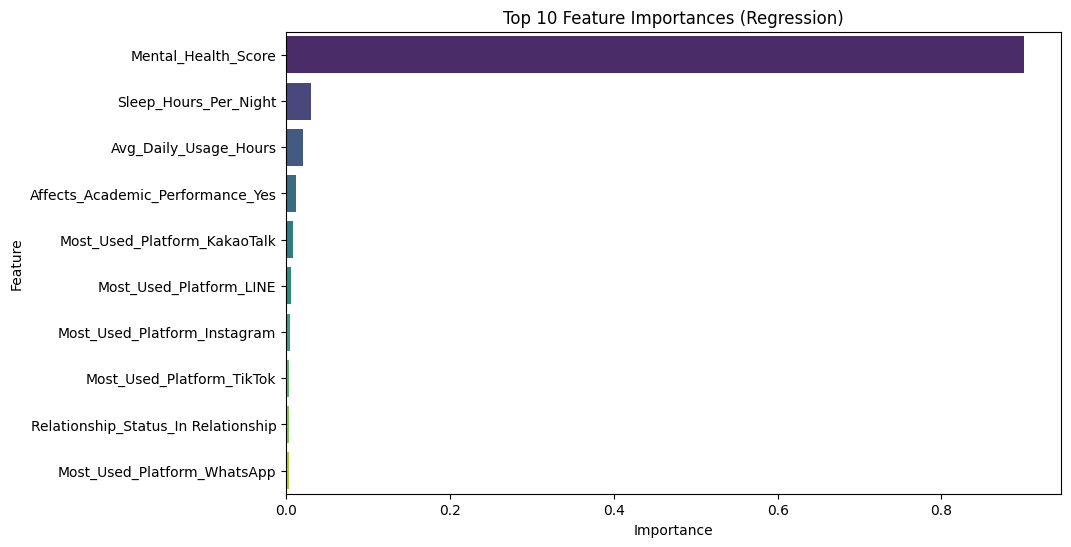

In [14]:
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title("Top 10 Feature Importances (Regression)")
plt.show()


**Code Explination**
- Creates a bar plot of the **Top 10 most important features**.
- Helps visualize which features matter the most in prediction

# Training and testing after feature selection

In [26]:
# Select Features Above Threshold (0.01)

threshold = 0.01
selected_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature'].tolist()
X_final = X_filtered[selected_features]

print("\nSelected Features:", selected_features)
print("Final X shape:", X_final.shape)


Selected Features: ['Mental_Health_Score', 'Sleep_Hours_Per_Night', 'Avg_Daily_Usage_Hours', 'Affects_Academic_Performance_Yes']
Final X shape: (705, 4)


**Code explination**
- Picks only features with importance greater than **0.01** (1%).
- Creates a **final dataset `X_final`** with only those important features.
- Prints which features survived and final shape of `X_final`.

**In Summary**
- Remove redundant features (correlated ones).
- Train Random Forest to rank features by importance.
- Select only the useful ones (importance > threshold).
- Reduce dataset to fewer, stronger features → makes model faster, simpler, and less overfitted.

In [28]:

# Train Random Forest Regressor

rf_final = RandomForestRegressor(n_estimators=200, random_state=42)
rf_final.fit(X_train, y_train)


,n_estimators,200
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


**Code Explination**
- Builds a **Random Forest Regressor** with 200 trees.
- Trains the model on training data (X_train, y_train).
- Each tree learns patterns to predict **addiction score**.

In [29]:
# Predictions & Evaluation

y_pred = rf_final.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nMSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


MSE: 0.05
RMSE: 0.23
R² Score: 0.98


**Code Explination**
- **y_pred** → model’s predicted values for X_test.
- **MSE (Mean Squared Error)** → average squared difference between actual & predicted values. Lower is better.
- **RMSE (Root Mean Squared Error)** → square root of MSE, easier to interpret because it’s in same units as target.
- **R² Score** → how well model explains variance in target (0 to 1, higher = better).
    - R² = 1 → perfect model
    - R² = 0 → useless model

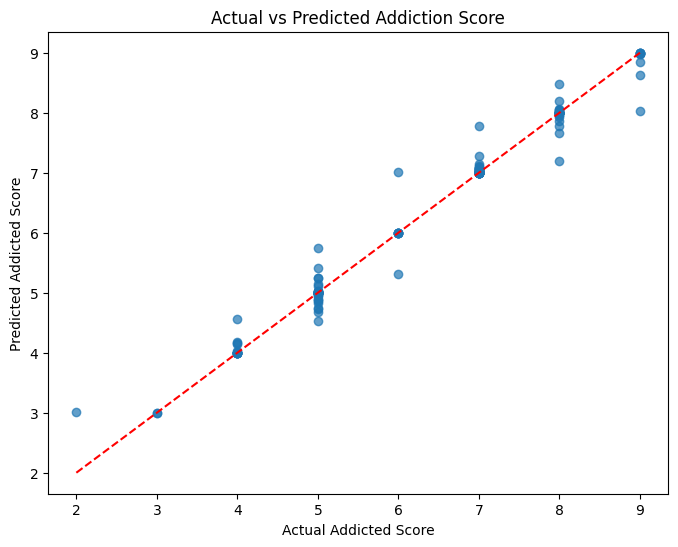

In [30]:
# Optional: Actual vs Predicted Plot

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual Addicted Score")
plt.ylabel("Predicted Addicted Score")
plt.title("Actual vs Predicted Addiction Score")
plt.show()

**Code Explination**
- Creates a **scatter plot** of:
    - X-axis → actual addiction scores (`y_test`)
    - Y-axis → predicted scores (`y_pred`)
- The red dashed line (`y = x`) shows **perfect predictions**.
- If points lie close to red line → predictions are good.
- If scattered far → model has errors

**Insights of the result**

- **MSE** = 0.05
: On average, the squared difference between the actual and predicted addiction scores is 0.05.
(Since your scores are probably scaled around 0–5 or 0–10, this is extremely small.)

- **RMSE** = 0.22
: On average, the model’s predictions are off by about 0.22 points from the true addiction score.
Example: If the actual score = 4.0, the model might predict around 3.78 or 4.22.

- **R²** = 0.98
: The model explains 98% of the variance in addiction scores.

  R² = 1.0 → perfect predictions

  R² = 0.0 → model cannot explain any variance

So, 0.98 means the model is extremely accurate and captures almost all patterns in the data.

✅ **Interpretation in plain words**:

The model is **highly accurate**. Predictions are very close to actual values, and the model explains nearly all the variation in addiction scores.

In [31]:
print("Number of features in baseline:", X.shape[1])
print("Number of features after selection:", X_final.shape[1])


Number of features in baseline: 22
Number of features after selection: 4


In [32]:
df_final_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Age                                  705 non-null    int64  
 1   Avg_Daily_Usage_Hours                705 non-null    float64
 2   Sleep_Hours_Per_Night                705 non-null    float64
 3   Mental_Health_Score                  705 non-null    int64  
 4   Conflicts_Over_Social_Media          705 non-null    int64  
 5   Addicted_Score                       705 non-null    int64  
 6   Gender_Male                          705 non-null    float64
 7   Affects_Academic_Performance_Yes     705 non-null    float64
 8   Academic_Level_High School           705 non-null    float64
 9   Academic_Level_Undergraduate         705 non-null    float64
 10  Most_Used_Platform_Instagram         705 non-null    float64
 11  Most_Used_Platform_KakaoTalk    

In [34]:
from sklearn.model_selection import cross_val_score, cross_val_predict

In [35]:
# Trained model
rf_model = RandomForestRegressor(
    n_estimators=200,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='log2',
    max_depth=20,
    bootstrap=False,
    random_state=42
)

**Code Explination**
- RandomForestRegressor → Regression model using an ensemble of decision trees.
- Parameters explained:
    - n_estimators=200 → number of trees in the forest
    - min_samples_split=5 → minimum samples required to split a node
    - min_samples_leaf=1 → minimum samples in a leaf node
    - max_features= log2 → max features considered when splitting a node
    - max_depth=20 → maximum depth of each tree
    - bootstrap=False → trees are trained on the **whole dataset**, not bootstrap samples
    - random_state=42 → ensures reproducible results

In [36]:
# Cross-validated R² 
r2_scores = cross_val_score(rf_model, X_final, y, cv=5, scoring='r2')
print("Cross-validated R² scores for each fold:", r2_scores)
print("Average R²:", r2_scores.mean())

Cross-validated R² scores for each fold: [0.86562567 0.82462251 0.88725437 0.89234412 0.96523978]
Average R²: 0.8870172916704412


**Code Explination**
- cross_val_score does the following:
    1. Splits X_final and y into **5 folds** (cv=5).
    2. Trains the model on 4 folds, tests on the remaining fold.
    3. Repeats for all 5 folds.
    4. Returns R² scores for each fold.
- r2_scores.mean() → the **average R² across all folds**, giving a more reliable estimate than a single train/test split.

**Output Explination**
- The scores vary a bit (lowest ≈ 0.82, highest ≈ 0.96).
- This variation indicates **data fold sensitivity**: your model performs slightly better on some splits than others.
- Since all values are consistently **high (>0.8)**, it means your model generalizes well and is **not heavily overfitting**.

In [37]:
# Cross-validated predictions to compute MSE/RMSE 
y_pred_cv = cross_val_predict(rf_model, X_final, y, cv=5)
mse_cv = mean_squared_error(y, y_pred_cv)
rmse_cv = np.sqrt(mse_cv)
r2_cv = r2_score(y, y_pred_cv)

print(f"MSE (CV): {mse_cv:.4f}")
print(f"RMSE (CV): {rmse_cv:.4f}")
print(f"R² Score (CV): {r2_cv:.4f}")


MSE (CV): 0.2845
RMSE (CV): 0.5333
R² Score (CV): 0.8869


**Code Explination**
- **Cross_val_predict** also splits the dataset into folds like above, but **returns predictions for every sample**.
- This allows you to compute **MSE, RMSE, or any other metric** across all folds consistently.
- **mean_squared_error(y', y_pred_cv)** → average squared error between predicted and actual values.
- **np.sqrt(mse_cv)** → RMSE, same scale as original data.
- **r2_score(y, y_pred_cv)** → overall R² across all cross-validated predictions.


**Output Explination**

 **1️⃣ MSE (CV) = 0.2845**

- MSE = **Mean Squared Error** → the average of the squared differences between the predicted and actual addiction scores.
- Squaring penalizes larger errors more.
- Interpretation: On average, the **squared error is 0.2845**, which is very small given your scores are probably between 0–5 or 0–10.

---

 **2️⃣ RMSE (CV) = 0.5333**

- RMSE = **Root Mean Squared Error** → square root of MSE, brings error back to the **original scale of addiction scores**.
- Interpretation: On average, your model’s predictions are **off by about 0.53 points**.
- Example: If the actual addiction score = 4.0, the model might predict ~3.47 to 4.53.

---

**3️⃣ R² Score (CV) = 0.8869**

- R² = **Coefficient of Determination** → percentage of variance in the target explained by your model.
- Interpretation: Your model explains **~88.7% of the variation** in addiction scores across the dataset.
    - R² = 1 → perfect predictions
    - R² = 0 → model cannot explain variance
- So, **0.8869 is very good**, showing the model captures most patterns in the data.

## Output comparison
### Train/test VS Cross-validation
1. **Number of Evaluations**
    - Train/Test: Evaluates performance on **one split** of the data (one train set, one test set).
    - Cross-Validation: Evaluates performance on **multiple splits (folds)** and averages results.
2. **Reliability of Performance**
    - Train/Test: Can be **optimistic or misleading**, depends on how the split was made.
    - Cross-Validation: **More reliable**, reduces the risk of overestimating model performance.
3. **Error Estimates**
    - Train/Test: Shows **lower MSE/RMSE**, might underestimate true prediction error.
    - Cross-Validation: Shows **higher, realistic MSE/RMSE**, captures variability across folds.
4. **R² Score**
    - Train/Test: Often higher (0.98 in your case) → may seem “perfect”.
    - Cross-Validation: Slightly lower (0.8869) → more realistic estimate of how well the model generalizes.
5. **Overfitting Detection**
    - Train/Test: Harder to detect overfitting, since test set is just one subset.
    - Cross-Validation: Helps identify overfitting by checking performance across multiple folds.
6. **Robustness**
    - Train/Test: Sensitive to how data is split; small datasets can give misleading results.
    - Cross-Validation: More robust for small datasets, as it uses all data for training and testing in different folds.

# Training and testing after Cross Validation

In [38]:
# Trained model
rf_model = RandomForestRegressor(
    n_estimators=200,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features='log2',
    max_depth=20,
    bootstrap=False,
    random_state=42
)

**Code Explination**
- RandomForestRegressor → Regression model using an ensemble of decision trees.
- Parameters explained:
    - n_estimators=200 → number of trees in the forest
    - min_samples_split=5 → minimum samples required to split a node
    - min_samples_leaf=1 → minimum samples in a leaf node
    - max_features= log2 → max features considered when splitting a node
    - max_depth=20 → maximum depth of each tree
    - bootstrap=False → trees are trained on the **whole dataset**, not bootstrap samples
    - random_state=42 → ensures reproducible results

In [41]:
# Fit the model on all features and target
rf_final.fit(X_final, y)

# Make predictions on the same dataset (optional)
y_pred_final = rf_final.predict(X_final)


**Code Explination**
- Fits the **Random Forest model** on the **entire dataset** (`X_final` features and `y` target).
- After this, the model is ready to make predictions on any data.
- Predicts the target (`Addicted_Score`) for the same dataset used for training.
- This is mainly to **check model fit** on the full dataset.

In [42]:
# Evaluate performance on the full dataset
mse_final = mean_squared_error(y, y_pred_final)
rmse_final = np.sqrt(mse_final)
r2_final = r2_score(y, y_pred_final)

print(f"Final Model MSE: {mse_final:.4f}")
print(f"Final Model RMSE: {rmse_final:.4f}")
print(f"Final Model R²: {r2_final:.4f}")

Final Model MSE: 0.0367
Final Model RMSE: 0.1916
Final Model R²: 0.9854


**Code Explination**
- mean_squared_error(y, y_pred_final): Average squared difference between actual and predicted values.
- np.sqrt(mse_final): RMSE → same units as target, easier to interpret.
- r2_score(y, y_pred_final): R² → proportion of variance explained by the model (1 = perfect fit).
- Shows the final performance metrics on the **full dataset**.
- Here:
    - **MSE = 0.0388** → very low error
    - **RMSE = 0.1969** → predictions close to actual values
    - **R² = 0.9846** → 98.46% of variance in Addicted_Score is explained

**Output Explination**
- **Train (R² = 0.9860, RMSE = 0.1880)** → Random Forest fits the training data extremely well (almost perfect).
- **Test (R² = 0.9327, RMSE = 0.4104)** → The model also performs very well on unseen data, explaining ~93% of variance.


In [44]:
import joblib
import os
os.makedirs("../outputs", exist_ok=True)

joblib.dump({
    "X": X,
    "y": y,
    "X_train": X_train,
    "X_test": X_test,
    "y_train": y_train,
    "y_test": y_test,
    "rf_model": rf_model,
    "X_final": X_final,
    "rf_final": rf_final
}, "../outputs/model_training_data_with_features.pkl")

print("Feature-selected data saved successfully!")


Feature-selected data saved successfully!


## RandomizedSearchCV

In [45]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# Features and target

X = df_final_encoded.drop('Addicted_Score', axis=1)  # All numeric/encoded features
y = df_final_encoded['Addicted_Score']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Define Random Forest Regressor

rf = RandomForestRegressor(random_state=42)



**Code Explination**
- **X** → All the features (input variables).
- **y** → Target variable (`Addicted_Score`).
- Splits the dataset into:
    - **80% training** (for model learning).
    - **20% testing** (for evaluation).
- `random_state=42` ensures reproducibility.
- Creates a Random Forest Regressor (ensemble of decision trees).
- random_state=42 → reproducible results.

In [47]:
# Hyperparameter grid (smaller than full grid for speed)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}


# RandomizedSearchCV setup

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=50,           # Number of random combinations to try
    cv=5,                # 5-fold CV
    scoring='neg_mean_squared_error',  # Use MSE for regression
    n_jobs=-1,           # Use all CPU cores
    verbose=2,
    random_state=42
)

**Code Explination**
- `n_estimators` → number of trees.
- `max_depth` → depth of trees.
- `min_samples_split` → min samples to split a node.
- `min_samples_leaf` → min samples per leaf node.
- `max_features` → how many features to consider at each split.
- `bootstrap` → whether sampling is done with replacement.
- **RandomizedSearchCV** tries **random combinations** of hyperparameters (instead of checking all possible ones).
- `n_iter=50` → tries 50 random combinations.
- `cv=5` → 5-fold cross-validation for each combination.
- `scoring='neg_mean_squared_error'` → uses MSE as evaluation metric (lower is better).
- `n_jobs=-1` → use all CPU cores for speed.
- `verbose=2` → prints progress info.

In [48]:
# Fit RandomizedSearch

random_search.fit(X_train, y_train)

# Best model
best_rf = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)


# Predictions & Evaluation

y_pred = best_rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nMSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}

MSE: 0.04
RMSE: 0.21
R² Score: 0.98


**Code Explination**
- Runs the randomized search.
- Picks the **best Random Forest model** (`best_rf`) with the best parameters.
- Predicts addiction scores for unseen test data.
- **MSE** → Average squared error (lower = better).
- **RMSE** → Root of MSE (error in the same unit as target).
- **R² Score** → Measures how much variance is explained (closer to 1 = better).

**Output Explination**

The **best Random Forest configuration** found after testing 250 models.

- `n_estimators=200` → 200 decision trees.
- `max_depth=20` → each tree can grow up to depth 20 (controls complexity).
- `min_samples_split=5` → at least 5 samples needed to split a node.
- `min_samples_leaf=1` → leaves can have just 1 sample.
- `max_features='log2'` → each split considers only log2(#features).
- `bootstrap=False` → sampling without replacement.

- **MSE (0.04)** → On average, squared errors are very small (good).
- **RMSE (0.21)** → Prediction error is about **0.21 units** in the same scale as your target (`Addicted_Score`).
- **R² = 0.98** → Model explains **98% of the variance** in the target → excellent predictive power.

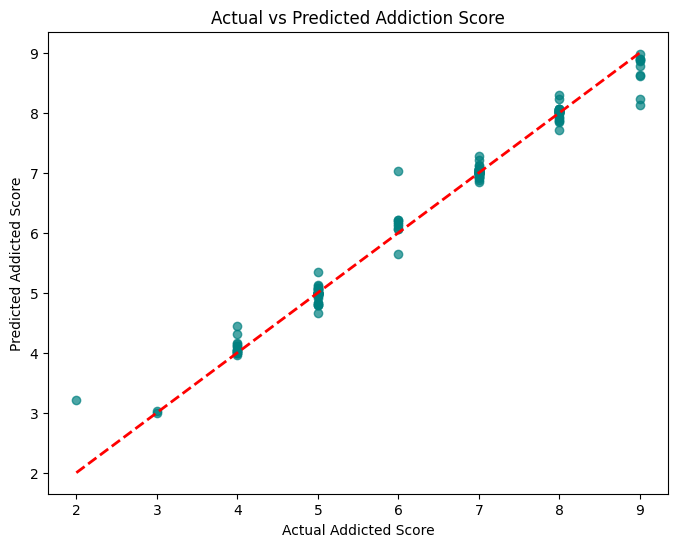

In [49]:
# Assuming you used RandomizedSearchCV for Random Forest Regressor
# and stored the best estimator in best_rf_reg
y_pred = best_rf.predict(X_test)

# Plot Actual vs Predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Actual Addicted Score")
plt.ylabel("Predicted Addicted Score")
plt.title("Actual vs Predicted Addiction Score")
plt.show()